# Modelo bolsa de palabras para sentiment analysis

## Planteamiento

Una técnica popular para desarrollar modelos de análisis de sentimientos es utilizar un modelo de bolsa de palabras que transforma los documentos en vectores donde a cada palabra del documento se le asigna una puntuación. Vamos a ver cómo:
 - Preparar los datos del texto para modelar un vocabulario restringido.
 - Utilizar el modelo de bolsa de palabra para preparar datos train/test.
 - Desarrollar un modelo de bolsa de palabras de perceptrón multicapa.
 
Entonces, vamos a dividirlo en los siguientes apartados:
 1. Conjunto de datos de reseñas de películas
 2. Preparación de datos
 3. Representación de bolsa de palabras
 4. Modelos de aprendizaje
 5. Comparación de métodos de puntuación de palabras
 6. Predicción en nuevas reseñas

# 1. Conjunto de datos de reseñas de películas

Vamos a seguir utilizando el mismo dataset que en la parte anterior.

# 2. Preparación de datos

Como tenemos en cuenta la limpieza anterior nos vamos a centrar en:
 - División en train/test
 - Cargar y limpiar los datos para eliminar puntuación y números
 - Definir un vocabulario de palabras preferidas
 
Vamos a decidir si una reseña dada por un usuario es buena o mala en función del texto que ponga. Esto quiere decir que para nuevos datos no etiquetados hay que realizar el mismo preprocesamiento de datos que en el conjunto de entrenamiento.

Haremos una división 90/10.

## 2.1 Carga y limpieza

Ya hemos observado que el texto está bastante limpio, por lo que no requiere mucha preparación. Entonces, vamos a realizar el siguiente preprocesamiento:
  - Dividir tokens en espacios en blanco
  - Eliminar toda puntuación de las palabras
  - Eliminar todas las palabras que no estén compuestas únicamente por caracteres alfanuméricos
  - Eliminar todas las palabras conocidas vacías
  - Eliminar las palabras cuya longitud sea $\leq$ 1
  
Para esto reutilizamos las funciones anteriores:
  - `load_doc()`, carga un documento desde un fichero listo para utilizar con la función `clean_doc()`
  - `clean_doc()`, recibe por parámetro un texto sin procesar y devuelve una lista de tokens limpios

In [1]:
from os import listdir

def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    
    return text

In [2]:
from nltk.corpus import stopwords
import string
import re

def clean_doc(text):
    tokens = text.split()
    
    # Eliminamos puntuación
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    re_punc = [re_punc.sub('', w) for w in tokens]
    
    # Eliminamos números
    tokens = [word for word in tokens if word.isalpha()]
    
    # Eliminamos las stop words
    stop_words = set(stopwords.words('English'))
    tokens = [w for w in tokens if not w in stop_words]
    
    tokens = [w for w in tokens if len(w) > 1]
    
    return tokens

## 2.2 Definir un vocabulario

Es importante limitar las palabras a aquellas que se crea que tenga poder predictivo.

Para esto vamos a reutilizar las funciones vistas. Primero, desarrollamos un vocabulario a modo de `Counter` y cada fragmento se puede agregar al contador y podemos cargar todas las reviews en un fichero.

In [3]:
from collections import Counter

def add_doc_to_vocab(filename, vocab):
    doc = load_doc(filename)
    tokens = clean_doc(doc)
    vocab.update(tokens)

In [4]:
def process_docs(directory, vocab):
    for filename in listdir(directory):
        if not filename.endswith('.txt'):
            continue
    
        path = directory + filename
        add_doc_to_vocab(path, 
                         vocab)

In [5]:
vocab = Counter()
pos_path = 'Data/review polarity/pos/'
neg_path = 'Data/review polarity/neg/'

process_docs(pos_path, vocab)
process_docs(neg_path, vocab)

print(len(vocab))

print(vocab.most_common(50))

37589
[('film', 8849), ('one', 5514), ('movie', 5429), ('like', 3543), ('even', 2554), ('good', 2313), ('time', 2280), ('story', 2110), ('would', 2041), ('much', 2022), ('also', 1965), ('get', 1920), ('character', 1902), ('two', 1824), ('characters', 1813), ('first', 1766), ('see', 1726), ('way', 1668), ('well', 1654), ('make', 1590), ('really', 1556), ('films', 1513), ('little', 1487), ('life', 1467), ('plot', 1448), ('people', 1418), ('could', 1395), ('bad', 1372), ('scene', 1372), ('never', 1360), ('best', 1298), ('new', 1275), ('many', 1267), ('scenes', 1262), ('man', 1255), ('know', 1207), ('movies', 1180), ('great', 1138), ('another', 1111), ('love', 1087), ('go', 1073), ('action', 1073), ('us', 1065), ('director', 1054), ('something', 1047), ('end', 1044), ('still', 1037), ('seems', 1032), ('back', 1031), ('made', 1025)]


Ahora vamos a eliminar todas las palabras que tengan menos de 2 ocurrencias.

In [6]:
umbral = 2
tokens = [k for k,c in vocab.items() if c>=umbral]

print(len(tokens))

24392


In [7]:
def save_list(lines, filename):
    data = '\n'.join(lines)
    file = open(filename,
                'w')
    file.write(data)
    file.close()

In [8]:
vocab_path = 'vocab.txt'

save_list(tokens, vocab_path)

# 3. Representación de la bolsa de palabras

Aspectos a tener en cuenta:
  - Cada documento se convierte en una representación vectorial.
  - El número de elementos en el vector que representa un documento corresponde al número de palabras en el vocabulario.
  - Cuanto mayor sea el vocabulario, mayor será la representación del vector, de ahí la preferencia por tener vocabularios más reducidos.

Ahora, vamos a convertir las reviews en vectores preparados para entrenar un modelo inicial de red neuronal, es decir:
  1. Convertir reseñas en tokens
  2. Codificarlas con una representación de modelo de bolsa de palabras

## 3.1 Reviews a líneas de tokens

Lo primero es realizar la limpieza de los documentos. Para ello, creamos la función `doc_to_line()` que cargará el documento, lo limpiará, filtrará los tokens que no están en el vocabulario y devolverá el documento como una cadena de tokens separados por espacios en blanco.

In [9]:
def doc_to_line(filename, vocab):
    doc = load_doc(filename)
    tokens = clean_doc(doc)
    tokens = [w for w in tokens if w in vocab]
    
    return ' '.join(tokens)

In [10]:
def process_docs(directory, vocab):
    lines = list()
 
    for filename in listdir(directory):
        if filename.startswith('cv9'):
            continue
        
        path = directory + filename
        line = doc_to_line(path, vocab)
        lines.append(line)
        
    return lines

Ahora vamos a crear una función `clean_load_dataset()` que llamará a `process_docs()` para construir el dataset en el que las revisiones positivas son 1 y las negativas 0.

In [11]:
def load_clean_dataset(vocab):
    neg = process_docs('Data/review polarity/neg/', 
                       vocab)
    pos = process_docs('Data/review polarity/pos/', 
                       vocab)
    
    docs = neg + pos 
    
    labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
    return docs, labels

Finalmente, tenemos que cargar el vocabulario y convertirlo en un conjunto para utilizar en revisiones de limpieza.

In [12]:
vocab = load_doc(vocab_path)
vocab = vocab.split()
vocab = set(vocab)

In [13]:
docs, labels = load_clean_dataset(vocab)

## 3.2 Reviews de películas a vectores de bolsa de palabra

La clase `Tokenizer` es conveniente y transformará fácilmente los documentos en vectores codificados. Primero, se debe crear el `Tokenizer` y, luego, realizar el `fit`.

En este caso, se trata de la agregación de matrices positive_lines y negative_lines.

In [14]:
from keras.preprocessing.text import Tokenizer

def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    
    return tokenizer

Los documentos se pueden codificar mediante `Tokenizer` con la función `texts_to_matrix()`, que tiene 2 parámetros:
  - Lista de documentos para codificar
  - Modo de codificación
      · Aquí específicamos `freq` para puntuar palabras en función de su frecuencia en el momento
      
Vamos a tener que modificar la función `process_docs()` para procesar de forma selectiva las reviews en train_test.
  - Admitimos la carga de train/test agregando un argumento `is_train` y usándolo para decidir qué nombres de archivos omitir.

In [15]:
def process_docs(directory, vocab, is_train):
    lines = list()
 
    for filename in listdir(directory):
        if is_train and filename.startswith('cv9'):
            continue
        
        if not is_train and not filename.startswith('cv9'):
            continue
        
        path = directory + filename
        line = doc_to_line(path, vocab)
        lines.append(line)
        
    return lines

Igualmente, vamos a tener que modificar la función `load_clean_dataset()` para cargar el train o test y asegurar que devuelva una matriz NumPy.

In [16]:
def load_clean_dataset(vocab, is_train):
    neg = process_docs('Data/review polarity/neg/', 
                       vocab,
                       is_train)
    
    pos = process_docs('Data/review polarity/pos/', 
                       vocab,
                       is_train)
    
    docs = neg + pos 
    
    labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
    return docs, labels

Ahora vamos a cargar todas las reviews

In [17]:
train_docs, y_train = load_clean_dataset(vocab, 
                                         True)
test_docs, y_test = load_clean_dataset(vocab, 
                                       False)

tokenizer = create_tokenizer(train_docs)

x_train = tokenizer.texts_to_matrix(train_docs,
                                   mode='freq')

x_test = tokenizer.texts_to_matrix(test_docs,
                                  mode='freq')

print(x_train.shape, x_test.shape)

(1800, 24208) (200, 24208)


Vemos que train y test tienen 1800 y 200 documentos, respectivamente, y cada uno con igual tamaño de vocabulario de codificación, es decir, 24208.

# 4. Modelos de análsis de reseñas

Vamos a implementar un modelo perceptrón multicapa para clasificar documentos codificados como positivos o negativos. Vamos a tener 3 partes:
  1. Primer modelo de análisis de reseña
  2. Comparación de los modos de puntuación de palabras
  3. Predicción para nuevas reseñas

## 4.1 Modelo de análisis de primera opinión

El modelo tendrá:
  - Una capa de entrada igual al número de palabras del vocabulario y, a su vez, la longitud de los documentos de entrada
  - Una sola capa oculta de 50 neuronas con función de activación ReLu
  - La capa de salida consta de una única neurona con función de activación sigmoidea
  - Optimizador ADAM
  - Función de pérdida `binary_crossentropy`
  - Evaluaremos accuracy al entrenar

In [18]:
from keras import Sequential
from keras.layers import Dense
from keras.utils import plot_model

def base_model(n_words):
    model = Sequential()
    
    model.add(Dense(50,
                   input_shape=(n_words, ),
                   activation='relu'
                   ))
    model.add(Dense(1,
                    activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model.summary()
    plot_model(model,
               to_file='model.png',
               show_shapes=True)
    
    return model

In [19]:
from numpy import array

n_words = x_test.shape[1]
y_train = array(y_train)
y_test = array(y_test)

model = base_model(n_words)

model.fit(x_train,
          y_train,
          epochs=10,
          verbose=2)

loss, acc = model.evaluate(x_test,
                           y_test,
                           verbose=0)

print('Accuracy en test: {:.2%}'.format(acc))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                1210450   
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1210501 (4.62 MB)
Trainable params: 1210501 (4.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
57/57 - 1s - loss: 0.6917 - accuracy: 0.5389 - 754ms/epoch - 13ms/step
Epoch 2/10
57/57 - 0s - loss: 0.6824 - accuracy: 0.8517 - 373ms/epoch - 7ms/step
Epoch 3/10
57/57 - 0s - loss: 0.6633 - accuracy: 0.8678 - 367ms/epoch - 6ms/step
Epoch 4/10
57/57 - 0s - loss: 0.6327 - accuracy: 0.8550 - 366ms/epoch - 6ms/step
Epoch 5/10
57/57 - 0s - loss: 0.5930 - accuracy: 0.9300 - 376ms/epoch - 7ms/step
Epoch 6/

Resumen del modelo:

![](model.png)

Vemos que:
  - El modelo se ajusta fácilmente a los datos de entrenamiento dentro de las 10 épocas, logrando un accuracy cerano al 100%
  - La evaluación es también es buena, logrando un accuracy superior al 87%

## 5 Comparación de métodos de puntuación de palabras

La función `texts_to_matrix()` proporciona 4 métodos diferentes para puntuar palabras, que son:
  - `binary`: Donde las palabras se marcan como presentes (1) o ausentes(0)
  - `count`: Donde el recuento de ocurrencias de cada palabra se marcan como un número entero
  - `tfidf`: Cada palabra se puntúa en función de su frecuencia, donde se penalizan las palabras comunes en todos los documentos
  - `freq`: Las palabras se puntuán en función de su frecuencia de aparición en el documento

Vamos a crear la función `prepare_data()`, que lo utilizaremos para crear los conjuntos train/test al llamarlo, en lugar de hacerlo manual, y indicando el modo en la función `texts_to_matrix()` en función de un parámetro.

In [20]:
def prepare_data(train_docs, test_docs, mode):
    tokenizer = create_tokenizer(train_docs)
    
    x_train = tokenizer.texts_to_matrix(train_docs,
                                        mode=mode)
    x_test = tokenizer.texts_to_matrix(test_docs,
                                       mode=mode)
    
    return x_train, x_test

In [21]:
def evaluate_model(xtrain, ytrain, xtest, ytest):
    scores = list()
    iterations = 10
    n_words = xtest.shape[1]
    
    for i in range(iterations):
        model = base_model(n_words)
        model.fit(xtrain,
                  ytrain,
                  epochs=10,
                  verbose=0)
        _, acc = model.evaluate(xtest,
                                ytest,
                                verbose=0)
        scores.append(acc)
        
    return scores

In [22]:
from pandas import DataFrame
from matplotlib import pyplot

train_docs, y_train = load_clean_dataset(vocab, 
                                         True)
test_docs, y_test = load_clean_dataset(vocab, 
                                       False)
y_train = array(y_train)
y_test = array(y_test)

modes = ['binary', 'count', 'tfidf', 'freq']

results = DataFrame()

for mode in modes:
    x_train, x_test = prepare_data(train_docs,
                                   test_docs,
                                   mode)
    results[mode] = evaluate_model(x_train,
                                   y_train,
                                   x_test,
                                   y_test)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 50)                1210450   
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1210501 (4.62 MB)
Trainable params: 1210501 (4.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 50)                1210450   
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                            

                                                                 
 dense_25 (Dense)            (None, 1)                 51        
                                                                 
Total params: 1210501 (4.62 MB)
Trainable params: 1210501 (4.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 50)                1210450   
                                                                 
 dense_27 (Dense)            (None, 1)                 51        
                                                                 
Total params: 1210501 (4.62 MB)
Trainable params: 1210501 (4.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_14"
____________________

Total params: 1210501 (4.62 MB)
Trainable params: 1210501 (4.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 50)                1210450   
                                                                 
 dense_49 (Dense)            (None, 1)                 51        
                                                                 
Total params: 1210501 (4.62 MB)
Trainable params: 1210501 (4.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 50)                1210450   
                    

 dense_70 (Dense)            (None, 50)                1210450   
                                                                 
 dense_71 (Dense)            (None, 1)                 51        
                                                                 
Total params: 1210501 (4.62 MB)
Trainable params: 1210501 (4.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 50)                1210450   
                                                                 
 dense_73 (Dense)            (None, 1)                 51        
                                                                 
Total params: 1210501 (4.62 MB)
Trainable params: 1210501 (4.62 MB)
Non-trainable params: 0 (0.00 Byte)
___________________________________________

          binary      count      tfidf       freq
count  10.000000  10.000000  10.000000  10.000000
mean    0.920500   0.894000   0.869500   0.872000
std     0.004972   0.008097   0.011655   0.016865
min     0.915000   0.885000   0.850000   0.840000
25%     0.916250   0.890000   0.865000   0.860000
50%     0.920000   0.892500   0.870000   0.880000
75%     0.923750   0.895000   0.877500   0.885000
max     0.930000   0.910000   0.885000   0.890000


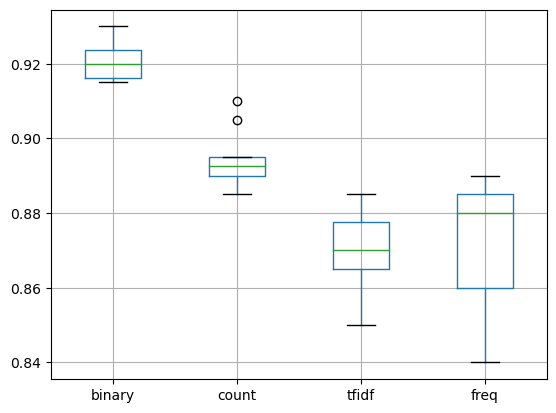

In [23]:
print(results.describe())

results.boxplot()
pyplot.show()

Como vemos, la puntuación media de `count` y `binary` parece ser mejor que `tfidf` y `freq`

## 6 Predicción de datos no etiquetados

Por último, podemos desarrollar y utilizar un modelo final para hacer predicciones para nuevas reviews no etiquetadas.
  - Primero, entrenamos un modelo final con todos lo datos disponibles.
  - Utilizaremos el modo binario para calificar el modelo.
  
Podemos hacer una predicción de un valor de clase directamente con el modelo de ajuste llamando a `predict()` que devolverá un entero de 0 para una review negativa y 1 para una positiva.

In [34]:
def predict_sentiment(review, vocab, tokenizer, model):
    tokens = clean_doc(review)
    tokens = [w for w in tokens if w in vocab]
    line = ' '.join(tokens)
    
    encoded = tokenizer.texts_to_matrix([line],
                                       mode='binary')
    yhat = model.predict(encoded,
                         verbose=0)
    percentage_pos = yhat[0,0]
    
    if round(percentage_pos) == 0:
        return (1-percentage_pos), 'Negativa'
    
    return percentage_pos, 'Positiva'

In [28]:
train_docs, y_train = load_clean_dataset(vocab, 
                                         True)
test_docs, y_test = load_clean_dataset(vocab, 
                                       False)
y_train = array(y_train)
y_test = array(y_test)

x_train, x_test = prepare_data(train_docs,
                               test_docs,
                               mode='binary')

n_words = x_test.shape[1]

model = base_model(n_words)

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 50)                1210450   
                                                                 
 dense_85 (Dense)            (None, 1)                 51        
                                                                 
Total params: 1210501 (4.62 MB)
Trainable params: 1210501 (4.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Realizamos el fit del modelo

In [30]:
model.fit(x_train,
          y_train,
          epochs=10,
          verbose=2)

Epoch 1/10
57/57 - 0s - loss: 0.0590 - accuracy: 0.9950 - 367ms/epoch - 6ms/step
Epoch 2/10
57/57 - 0s - loss: 0.0171 - accuracy: 1.0000 - 376ms/epoch - 7ms/step
Epoch 3/10
57/57 - 0s - loss: 0.0083 - accuracy: 1.0000 - 409ms/epoch - 7ms/step
Epoch 4/10
57/57 - 0s - loss: 0.0047 - accuracy: 1.0000 - 390ms/epoch - 7ms/step
Epoch 5/10
57/57 - 0s - loss: 0.0030 - accuracy: 1.0000 - 391ms/epoch - 7ms/step
Epoch 6/10
57/57 - 0s - loss: 0.0020 - accuracy: 1.0000 - 400ms/epoch - 7ms/step
Epoch 7/10
57/57 - 0s - loss: 0.0014 - accuracy: 1.0000 - 400ms/epoch - 7ms/step
Epoch 8/10
57/57 - 0s - loss: 0.0011 - accuracy: 1.0000 - 408ms/epoch - 7ms/step
Epoch 9/10
57/57 - 0s - loss: 8.5388e-04 - accuracy: 1.0000 - 407ms/epoch - 7ms/step
Epoch 10/10
57/57 - 0s - loss: 6.8827e-04 - accuracy: 1.0000 - 409ms/epoch - 7ms/step


Vamos a crear alguna reseña nosotros de prueba para verificar los resultados.

In [40]:
text_pos = 'Steeped in enigmatic allure,the film seamlessly weaves a tapestry of emotions, leaving the audience with a delightful ambiguity that sparks contemplation. The narrative dances gracefully between light and shadow, inviting viewers to traverse the intricate maze of the human experience. The characters, shrouded in a captivating mystique, resonate with a nuanced authenticity that lingers in the mind long after the credits roll. A cinematic enigma that beckons you to explore its depths, this film is a mesmerizing journey into the sublime, where every frame is a brushstroke on the canvas of cinematic brilliance'
percentage, sentiment = predict_sentiment(text_pos,
                                          vocab,
                                          tokenizer,
                                          model)
print()
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text_pos, sentiment, percentage*100))

text_neg = 'In the realm of cinema, this film stands as a perplexing misstep, stumbling through a narrative that feels disjointed and uninspired. From the outset, the plot meanders aimlessly, failing to engage the audience with any semblance of coherence. Characters, poorly developed and devoid of relatability, drift through scenes like mere placeholders in a forgettable storyline. The dialogue, instead of providing depth, often descends into banality, leaving viewers yearning for substance. The cinematography, rather than elevating the viewing experience, feels mundane and lacks the visual poetry that could have breathed life into this lackluster production. Despite a potentially intriguing premise, the film ultimately collapses under the weight of its own mediocrity, leaving behind a trail of unfulfilled potential and viewer disappointment.'

print()

percentage, sentiment = predict_sentiment(text_neg,
                                          vocab,
                                          tokenizer,
                                          model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text_neg, sentiment, percentage*100))


Review: [Steeped in enigmatic allure,the film seamlessly weaves a tapestry of emotions, leaving the audience with a delightful ambiguity that sparks contemplation. The narrative dances gracefully between light and shadow, inviting viewers to traverse the intricate maze of the human experience. The characters, shrouded in a captivating mystique, resonate with a nuanced authenticity that lingers in the mind long after the credits roll. A cinematic enigma that beckons you to explore its depths, this film is a mesmerizing journey into the sublime, where every frame is a brushstroke on the canvas of cinematic brilliance]
Sentiment: Positiva (86.958%)

Review: [In the realm of cinema, this film stands as a perplexing misstep, stumbling through a narrative that feels disjointed and uninspired. From the outset, the plot meanders aimlessly, failing to engage the audience with any semblance of coherence. Characters, poorly developed and devoid of relatability, drift through scenes like mere pla